# Simple GAN Model with Class

## Preparation

### Load the Library

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

tf.__version__         # python=3.9

'2.7.4'

### Prepare Training Data

In [2]:
# When training the model, the label of the real-image is set to "real(1)".
# (So there is no need to bring)
(train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()

# In addition, data preprocessing(dimension-expansion, normalization) is handled by the class

## Implementation GAN Model Class

In [3]:
class SimpleGAN:
    
    def __init__(self, data, epochs=20000, batch_size=128, latent_z_dim=100, num_display_log=20):
        self.preprocessing_data(data)
        self.input_shape = self.data.shape[1:]
        self.input_size = self.input_shape[0] * self.input_shape[1] * self.input_shape[2]
        self.epochs = epochs
        self.epochs_size = len(str(self.epochs))
        self.batch_size = batch_size
        self.latent_z_dim = latent_z_dim
        self.num_display_log = num_display_log
        self.epochs_display_log = self.epochs // self.num_display_log
        
        self.build_generator()
        self.build_discriminator()
        self.build_gan_model()
        
        self.losses = []
        self.accuracies = []
        self.epoch_checkpoints = []
        
        self.real_label, self.fake_label = np.ones((self.batch_size, 1)), np.zeros((self.batch_size, 1))
        
        self.is_training = False
        
    
    def preprocessing_data(self, data):
        data_dim = data.ndim
        if data_dim not in [3, 4]:
            raise TypeError(f"The expected dimensions of the input data are 3 or 4 "
                            f"dimensions, but {data_dim} dimensions were found.")
        self.data = data / 127.5 - 1.
        if data_dim == 3:
            self.data = np.expand_dims(self.data, axis=3)
            
    def build_generator(self):
        self.generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, input_dim=self.latent_z_dim),
            tf.keras.layers.LeakyReLU(alpha=0.01),
            tf.keras.layers.Dense(self.input_size, activation="tanh"),
            tf.keras.layers.Reshape(self.input_shape)
        ])
    
    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=self.input_shape),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(alpha=0.01),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        self.discriminator.compile(loss="binary_crossentropy",
                                   optimizer=tf.keras.optimizers.Adam(),
                                   metrics=["accuracy"])
        
    def build_gan_model(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([
            self.generator,
            self.discriminator
        ])
        self.gan.compile(loss="binary_crossentropy",
                         optimizer=tf.keras.optimizers.Adam())
        
    def train(self):
        start_train = datetime.now()
        print(f"Start Training - Data Shape: {self.data.shape}, "
              f"Epochs: {self.epochs}, Batch Size: {self.batch_size}, "
              f"Time: {start_train}")
        
        start_loop = datetime.now()
        for epoch in range(self.epochs):
            train_x, train_y = self.get_discriminator_train_data()
            d_loss, d_acc = self.discriminator.train_on_batch(train_x, train_y)
            train_x, train_y = self.get_gan_train_data()
            g_loss = self.gan.train_on_batch(train_x, train_y)
            if (epoch+1) % self.epochs_display_log == 0:
                self.losses.append((d_loss, g_loss))
                self.accuracies.append(d_acc * 100)
                self.epoch_checkpoints.append(epoch+1)
                end_loop = datetime.now()
                num_curr_loop = (epoch+1) // self.epochs_display_log
                print(f"{epoch+1: >6}({num_curr_loop: >2}/{self.num_display_log}), "
                      f"[D loss: {d_loss:8.6f}, accuracy: {d_acc:8.6f}], "
                      f"[G loss: {d_loss:8.6f}], "
                      f"Time[Curr: {end_loop-start_loop}, Total: {end_loop-start_train}, "
                      f"ETA: {self.get_eta(self.num_display_log-num_curr_loop, end_loop-start_loop)}]")
                start_loop = end_loop
        
        end_train = datetime.now()
        print(f"End Training - Time: {end_train}, "
              f"Total Processing Time: {end_train-start_train}")
        
        self.is_training = True

    def get_discriminator_train_data(self):
        real_idx = np.random.randint(0, self.data.shape[0], self.batch_size)
        real_images = self.data[real_idx]
        latent_data = np.random.normal(0, 1, (self.batch_size, self.latent_z_dim))
        fake_images = self.generator.predict(latent_data, verbose=0)
        train_x = np.vstack([real_images, fake_images])
        train_y = np.vstack([self.real_label, self.fake_label])
        shuffle_idx = np.arange(train_x.shape[0])
        np.random.shuffle(shuffle_idx)
        train_x = train_x[shuffle_idx]
        train_y = train_y[shuffle_idx]
        return train_x, train_y
    
    def get_gan_train_data(self):
        return np.random.normal(0,1,(self.batch_size, self.latent_z_dim)), self.real_label
    
    def get_eta(self, loop_cnt, curr_time):
        return datetime.now() + curr_time * loop_cnt
    
    def display_last_generation_images(self, grid_rows=4, grid_cols=4):
        if not self.is_training:
            raise RuntimeError("The generative model has not yet been trained.")
        
        gen_latent_noise = np.random.normal(0, 1, (grid_rows * grid_cols, self.latent_z_dim))
        gen_images = self.generator.predict(gen_latent_noise, verbose=0)
        gen_images = gen_images * .5 + .5
        
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_rows, grid_cols), sharey=True, sharex=True)
        display_idx = 0
        for i in range(grid_rows):
            for j in range(grid_cols):
                axs[i,j].imshow(gen_images[display_idx, :, :, 0], cmap="gray")
                axs[i,j].axis("off")
                display_idx += 1

## Create Model and Training

In [4]:
model = SimpleGAN(train_x, epochs=10000)
model.train()

2022-10-06 10:00:51.273698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 10:00:52.642349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-10-06 10:00:52.643580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22026 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


Start Training - Data Shape: (60000, 28, 28, 1), Epochs: 10000, Batch Size: 128, Time: 2022-10-06 10:00:52.730125
   500( 1/20), [D loss: 0.023926, accuracy: 1.000000], [G loss: 0.023926], Time[Curr: 0:00:50.933534, Total: 0:00:50.933637, ETA: 2022-10-06 10:17:51.401167]
  1000( 2/20), [D loss: 0.125789, accuracy: 0.957031], [G loss: 0.125789], Time[Curr: 0:00:47.237958, Total: 0:01:38.171595, ETA: 2022-10-06 10:16:41.185165]
  1500( 3/20), [D loss: 0.259498, accuracy: 0.894531], [G loss: 0.259498], Time[Curr: 0:00:46.078735, Total: 0:02:24.250330, ETA: 2022-10-06 10:16:20.319115]
  2000( 4/20), [D loss: 0.916947, accuracy: 0.695312], [G loss: 0.916947], Time[Curr: 0:00:47.566122, Total: 0:03:11.816452, ETA: 2022-10-06 10:16:45.604586]
  2500( 5/20), [D loss: 0.253731, accuracy: 0.871094], [G loss: 0.253731], Time[Curr: 0:00:46.639038, Total: 0:03:58.455490, ETA: 2022-10-06 10:16:30.771297]
  3000( 6/20), [D loss: 0.533659, accuracy: 0.742188], [G loss: 0.533659], Time[Curr: 0:00:47.36

### Result

#### HomePC

```
 10000(20/20), [D loss: 0.940526, accuracy: 0.550781], [G loss: 0.940526], Time[Curr: 0:00:19.044228, Total: 0:06:22.209028, ETA: 2022-10-05 22:25:18.921628]
End Training - Time: 2022-10-05 22:25:18.921679, Total Processing Time: 0:06:22.209098
```

#### Office Server

```
 10000(20/20), [D loss: 0.563736, accuracy: 0.792969], [G loss: 0.563736], Time[Curr: 0:00:46.923977, Total: 0:15:44.149594, ETA: 2022-10-06 10:16:36.879790]
End Training - Time: 2022-10-06 10:16:36.880036, Total Processing Time: 0:15:44.149911
```

## Display Last Generation Images

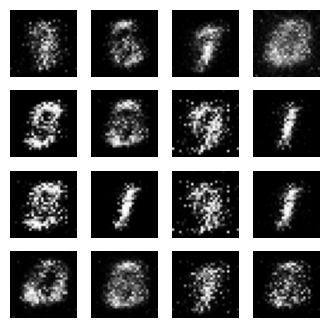

In [5]:
model.display_last_generation_images()

### Result

<img src="../result_files/images/gan_last_generation_images_homepc.png"> <br/>
```../result_files/images/gan_last_generation_images_homepc.png```

<img src="../result_files/images/gan_last_generation_images_officeserver.png"> <br/>
```../result_files/images/gan_last_generation_images_officeserver.png```